# Community Detection Protein Coelution
***Analyzing Protein Coelution***

In [73]:
import pandas as pd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import markov_clustering as mc
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Load Data
***There are 72 fractions from 2 biological replicates: Replicate1 & Replicate2***

In [74]:
community = pd.read_csv(r'D:\BNFO286\Kaggle\bnfo286coelution\repl1_repl2_combined.tsv', header = 0, sep="\t")
community.head()

,xxx,repl1_1,repl1_2,repl1_3,repl1_4,repl1_5,repl1_6,repl1_7,repl1_8,repl1_9,...,repl2_63,repl2_64,repl2_65,repl2_66,repl2_67,repl2_68,repl2_69,repl2_70,repl2_71,repl2_72
0,0002Y95AH,NaN,NaN,NaN,2.263669,22.128841,51.762737,52.550846,49.825542,48.441952,...,553.849060,274.200378,286.662445,112.624908,47.87561,59.853748,63.270977,27.508387,30.672783,32.651031
1,00BDGD39O,NaN,NaN,4.324259,19.600451,80.607506,172.490936,179.236649,158.082748,139.140900,...,4.175920,NaN,3.220537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00BXY8FC6,NaN,NaN,5.754857,11.839447,53.564465,89.967712,76.064796,87.056900,74.854607,...,4.823446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00GQL2IWT,NaN,NaN,NaN,2.807737,13.327758,24.826971,23.496061,25.944332,24.684835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00W2KCFX9,NaN,NaN,3.518204,7.602578,29.471481,78.761925,75.764984,56.365299,48.396515,...,NaN,4.695970,3.909930,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocess for the Missing Value and NaN

In [75]:
community_a = community.fillna(0)
community_a.head()

,xxx,repl1_1,repl1_2,repl1_3,repl1_4,repl1_5,repl1_6,repl1_7,repl1_8,repl1_9,...,repl2_63,repl2_64,repl2_65,repl2_66,repl2_67,repl2_68,repl2_69,repl2_70,repl2_71,repl2_72
0,0002Y95AH,0.0,0.0,0.000000,2.263669,22.128841,51.762737,52.550846,49.825542,48.441952,...,553.849060,274.200378,286.662445,112.624908,47.87561,59.853748,63.270977,27.508387,30.672783,32.651031
1,00BDGD39O,0.0,0.0,4.324259,19.600451,80.607506,172.490936,179.236649,158.082748,139.140900,...,4.175920,0.000000,3.220537,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,00BXY8FC6,0.0,0.0,5.754857,11.839447,53.564465,89.967712,76.064796,87.056900,74.854607,...,4.823446,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,00GQL2IWT,0.0,0.0,0.000000,2.807737,13.327758,24.826971,23.496061,25.944332,24.684835,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,00W2KCFX9,0.0,0.0,3.518204,7.602578,29.471481,78.761925,75.764984,56.365299,48.396515,...,0.000000,4.695970,3.909930,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


# Visualize the coelution for proteins

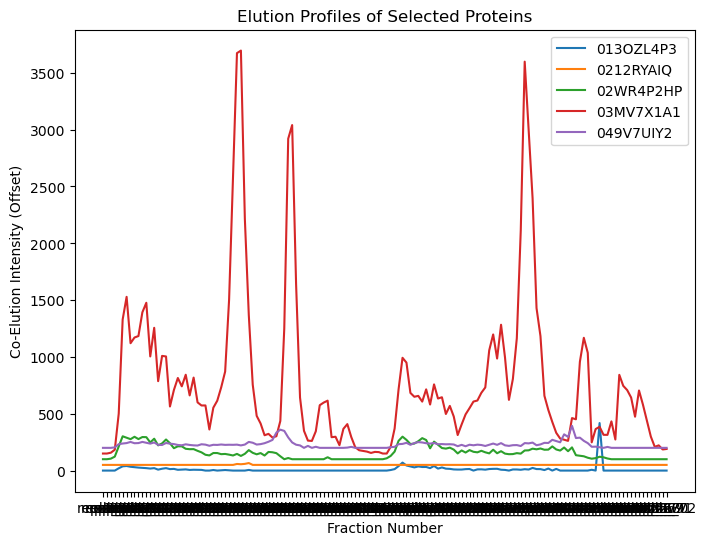

In [76]:
# Select 5 proteins (you can modify the indices as needed)
protein_indices = [5, 10, 15, 20, 25]  # Adjust these indices based on dataset
plt.figure(figsize=(8, 6))

for i, idx in enumerate(protein_indices):
    protein_id = community_a.iloc[idx, 0]  # Get protein ID
    protein_values = community_a.iloc[idx, 1:]  # Extract elution profile

    # Offset y-values to make the graph stacked (for better visibility)
    plt.plot(protein_values + i * 50, label=f"{protein_id}")  

# Labels and title
plt.xlabel("Fraction Number")
plt.ylabel("Co-Elution Intensity (Offset)")
plt.title("Elution Profiles of Selected Proteins")
plt.legend()
plt.show()

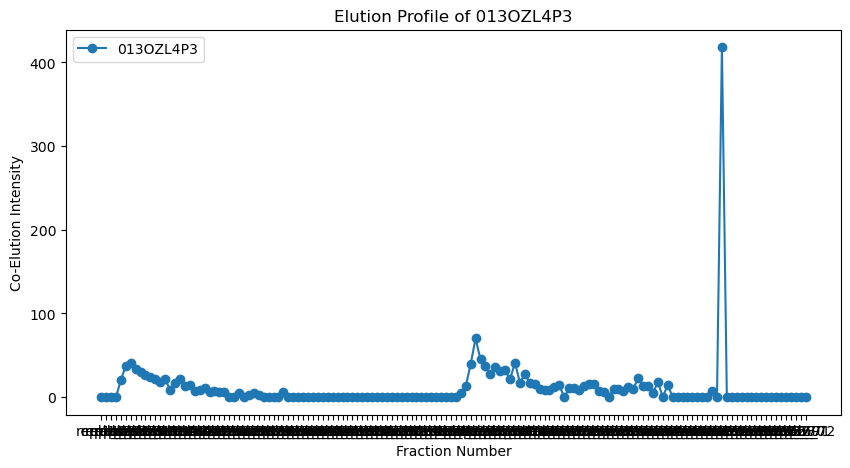

In [77]:
# Select a protein row (e.g., sixth protein)
protein_id = community_a.iloc[5, 0]  # Get protein ID
protein_values = community_a.iloc[5, 1:]  # Exclude ID column

# Plot elution profile
plt.figure(figsize=(10, 5))
plt.plot(protein_values, marker='o', linestyle='-', label=protein_id)
plt.xlabel("Fraction Number")
plt.ylabel("Co-Elution Intensity")
plt.title(f"Elution Profile of {protein_id}")
plt.legend()
plt.show()

# Detect correlation in replicate1

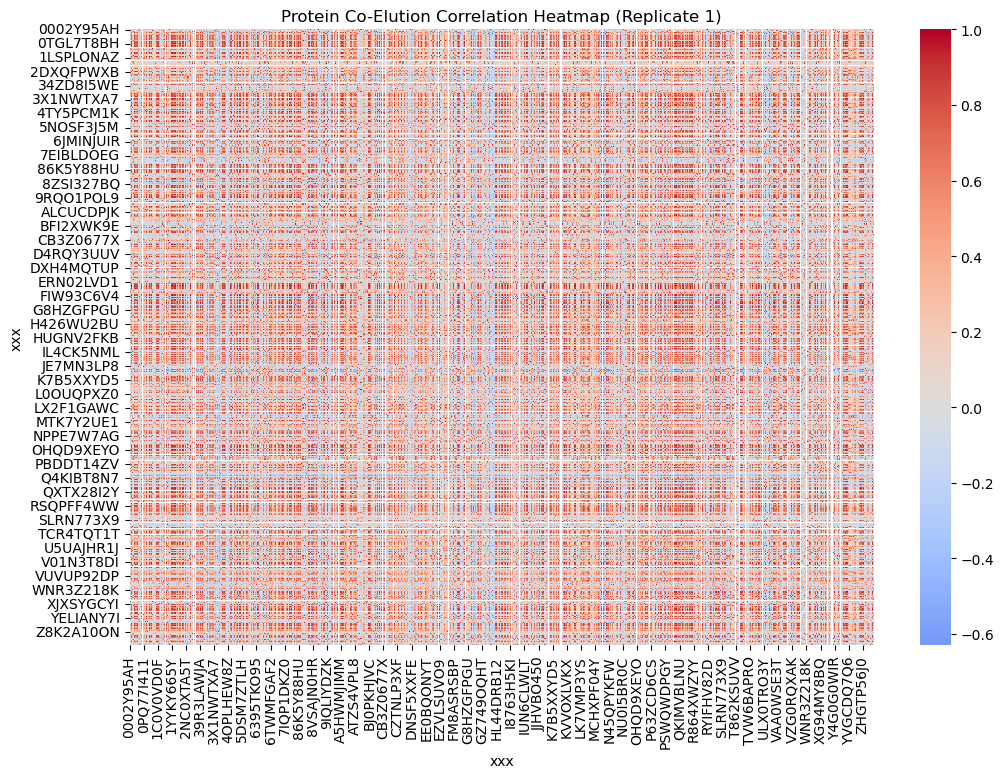

In [42]:
# Extract only replicate 1 fractions (excluding protein ID column)
repl1_data = community_a.iloc[:, 1:73]  # Adjust column range based on your dataset
protein_names = community_a["xxx"]  # Store protein IDs

# Compute Pearson correlation between proteins
corr_matrix = repl1_data.T.corr(method='pearson')

# Plot heatmap
corr_matrix.index = protein_names
corr_matrix.columns = protein_names
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Protein Co-Elution Correlation Heatmap (Replicate 1)")
plt.show()

In [80]:
corr_matrix.index = community_a["xxx"].values
corr_matrix.columns = community_a["xxx"].values
corr_matrix

,0002Y95AH,00BDGD39O,00BXY8FC6,00GQL2IWT,00W2KCFX9,013OZL4P3,01E274Y0C,01FAGPAVL,01FTWI84P,01KIIEDQ4,...,ZY8TJP5HW,ZYB2XIVKR,ZYIJBOMLO,ZYOOMGYJ0,ZYS4LWTG1,ZYYC3F693,ZZBWF4AM0,ZZRFYDD69,ZZTMEGI9I,ZZYCBGA8G
0002Y95AH,1.000000,-0.187911,-0.035720,-0.220506,-0.228713,-0.063935,-0.061863,-0.245657,0.840471,-0.155196,...,-0.182331,0.015774,-0.079390,-0.090118,0.020518,0.471301,-0.175165,-0.023373,-0.109075,0.035124
00BDGD39O,-0.187911,1.000000,0.290901,0.481363,0.832896,0.219594,0.431728,0.402430,-0.109330,0.593993,...,0.826725,0.413255,0.367307,0.687713,-0.149957,0.164571,0.755178,-0.085749,0.287959,-0.005922
00BXY8FC6,-0.035720,0.290901,1.000000,-0.224646,0.100594,-0.065569,0.040758,-0.187304,-0.018597,-0.159130,...,0.091906,0.955641,-0.044786,-0.050362,-0.074769,-0.029230,-0.076975,-0.026040,-0.117149,0.007075
00GQL2IWT,-0.220506,0.481363,-0.224646,1.000000,0.656780,0.210217,0.161479,0.864656,-0.123552,0.807044,...,0.614019,-0.170881,0.266975,0.538250,0.036870,0.065351,0.801334,-0.074045,0.432040,-0.072571
00W2KCFX9,-0.228713,0.832896,0.100594,0.656780,1.000000,0.239053,0.228155,0.674754,-0.144660,0.659912,...,0.725774,0.269500,0.602991,0.591131,-0.089303,0.065321,0.806949,-0.088067,0.450688,-0.078131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYYC3F693,0.471301,0.164571,-0.029230,0.065351,0.065321,0.026254,0.294457,-0.033973,0.676907,0.165908,...,0.269408,0.031625,-0.062991,0.192493,-0.001677,1.000000,0.168816,-0.014654,0.125945,-0.037623
ZZBWF4AM0,-0.175165,0.755178,-0.076975,0.801334,0.806949,0.268440,0.369207,0.720297,-0.098168,0.892774,...,0.823858,0.008013,0.465290,0.766596,-0.077559,0.168816,1.000000,-0.062781,0.516036,-0.078026
ZZRFYDD69,-0.023373,-0.085749,-0.026040,-0.074045,-0.088067,-0.026241,-0.020596,-0.094602,-0.012553,-0.052763,...,-0.066674,-0.043393,-0.031946,-0.030878,-0.034734,-0.014654,-0.062781,1.000000,-0.034829,-0.018154
ZZTMEGI9I,-0.109075,0.287959,-0.117149,0.432040,0.450688,0.173879,0.030858,0.558059,-0.060581,0.423634,...,0.373808,-0.088014,0.503660,0.104002,0.006103,0.125945,0.516036,-0.034829,1.000000,-0.094263


In [99]:
corr_matrix_mean = np.nanmean(corr_matrix)
corr_matrix_std = np.nanstd(corr_matrix)
corr_z_score = (corr_matrix-corr_matrix_mean)/corr_matrix_std
print("Standardized Z-score of protein correlation:\n", corr_z_score)

Standardized Z-score of protein correlation:
           0         1         2         3         4         5         6     \
0     2.953086 -1.266333 -0.725757 -1.382110 -1.411258 -0.825974 -0.818614   
1    -1.266333  2.953086  0.434390  1.110906  2.359538  0.181111  0.934604   
2    -0.725757  0.434390  2.953086 -1.396814 -0.241573 -0.831778 -0.454108   
3    -1.382110  1.110906 -1.396814  2.953086  1.733979  0.147805 -0.025312   
4    -1.411258  2.359538 -0.241573  1.733979  2.953086  0.250227  0.211520   
...        ...       ...       ...       ...       ...       ...       ...   
8173  1.075167 -0.014329 -0.702703 -0.366756 -0.366860 -0.505626  0.447022   
8174 -1.221057  2.083488 -0.872291  2.247431  2.267374  0.354609  0.712530   
8175 -0.681901 -0.903455 -0.691373 -0.861883 -0.911689 -0.692086 -0.672034   
8176 -0.986311  0.423939 -1.014989  0.935712  1.001949  0.018734 -0.489274   
8177 -0.474119 -0.619912 -0.573750 -0.856650 -0.876399  0.555011 -0.378972   

          7      

In [102]:
# Ensure that index names are kept
corr_z_score.index = community_a["xxx"].values
corr_z_score.columns = community_a["xxx"].values

# Convert correlation matrix into a DataFrame of protein name pairs
pairwise_corr = corr_z_score.stack().reset_index()
pairwise_corr.columns = ["Protein_A", "Protein_B", "Correlation"]

# Remove self-correlations
pairwise_corr = pairwise_corr[pairwise_corr["Protein_A"] != pairwise_corr["Protein_B"]]

# Display correct protein names
print(pairwise_corr[["Protein_A", "Protein_B", "Correlation"]].sort_values("Correlation", ascending=False).head(100))


          Protein_A  Protein_B  Correlation
37629406  JZR2T3GH0  UUIWX4568     2.953086
57480734  UUIWX4568  JZR2T3GH0     2.953086
37626337  JZR2T3GH0  HCPV359OV     2.953086
32385521  HCPV359OV  JZR2T3GH0     2.953086
37626307  JZR2T3GH0  H7CYXAK43     2.953086
...             ...        ...          ...
36714140  JI1E9NUER  XF3DBO5JX     2.948129
14802759  80B0OA8OU  AGJGVH9MO     2.948096
19536663  AGJGVH9MO  80B0OA8OU     2.948096
34781270  IHJO63F35  JI1E9NUER     2.947945
36710806  JI1E9NUER  IHJO63F35     2.947945

[100 rows x 3 columns]


# filtered

In [104]:
# Filter strong interactions based on the adjusted threshold
threshold_corr=pairwise_corr["Correlation"].quantile(0.95)
strong_interactions = pairwise_corr[pairwise_corr["Correlation"] > threshold_corr]

print(f"New threshold: {threshold_corr}")
print(f"Remaining interactions after filtering: {len(strong_interactions)}")

New threshold: 1.9662192800848115
Remaining interactions after filtering: 3342758


# Louvain Clustering

In [130]:
# Create an undirected graph from strong interactions
G = nx.Graph()

# Add edges between strongly correlated proteins
for _, row in strong_interactions.iterrows():
    G.add_edge(row["Protein_A"], row["Protein_B"], weight=row["Correlation"])

print(f"Graph has {G.number_of_nodes()} proteins and {G.number_of_edges()} interactions.")

Graph has 7719 proteins and 1671379 interactions.
Graph with 7719 nodes and 1671379 edges


In [122]:
from community import community_louvain
partition=community_louvain.best_partition(G)
louvain_results=pd.DataFrame(list(partition.items()), columns=["Protein", "Cluster"])
# Ensure Cluster column is integer (avoiding "clustX.0" issue)
louvain_results["Cluster"] = louvain_results["Cluster"]
print(louvain_results.head())

     Protein  Cluster
0  0002Y95AH        1
1  01FTWI84P        1
2  0N7YH30IP        1
3  0ROFT5TRV        1
4  0XAE7ASA9        1


In [129]:
# Merge clustering results with the main dataframe
community_a = community_a.merge(louvain_results, left_on="xxx", right_on="Protein", how="left").drop(columns=["Protein"])

# Remove duplicate 'prediction' column if it exists
if "prediction" in community_a.columns:
    community_a = community_a.drop(columns=["prediction"])

# Convert Cluster to integer before renaming
community_a["Cluster"] = community_a["Cluster"].fillna(-1).astype(int)
community_a.rename(columns={"Cluster": "prediction"}, inplace=True)
community_a["prediction"] = community_a["prediction"].astype(int)  # Convert to integer first
community_a["prediction"] = "clust" + community_a["prediction"].astype(str)  # Apply "clustX" format

# Select final output format
output = community_a[["xxx", "prediction"]].copy()
output.insert(0, "id", range(len(output)))  # Add an "id" column starting from 0

# Save the final clustering results
output.to_csv("louvain_coelution_cluster.csv", index=False)

# Print output for debugging
print(output.head())


   id        xxx prediction
0   0  0002Y95AH     clust1
1   1  00BDGD39O     clust2
2   2  00BXY8FC6     clust5
3   3  00GQL2IWT     clust4
4   4  00W2KCFX9    clust25
